### 1. Import

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.datasets import CIFAR10

/home/yukik/.pyenv/versions/3.10.7/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2. Dataset

In [2]:

transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = CIFAR10(root='data', 
                        train=True, 
                        transform=transform,
                        download=True)
train_dataset, val_dataset = random_split(train_dataset, [40000, 10000])
test_dataset = CIFAR10(root='data', 
                        train=False, 
                        transform=transform,
                        download=True)

Files already downloaded and verified
Files already downloaded and verified


### 3.　可視化

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


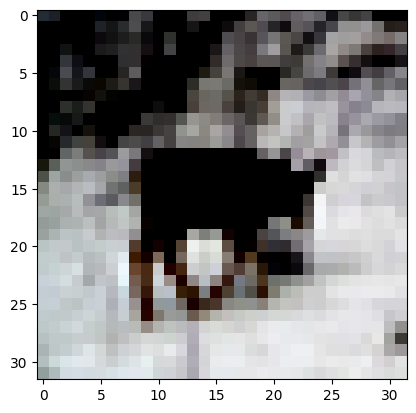

In [3]:
import matplotlib.pyplot as plt

plt.imshow(train_dataset[4][0].permute(1, 2, 0))
plt.show()
plt.close()

### 4. Data Loader

In [4]:
train_loader = DataLoader(dataset=train_dataset, batch_size=128, num_workers=4, shuffle=True)
val_loader   = DataLoader(dataset=val_dataset,   batch_size=128, num_workers=4, shuffle=False)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=128, num_workers=4, shuffle=False)

### 5. ViTを実装する

In [9]:
from timm.models.vision_transformer import VisionTransformer, _cfg

model = VisionTransformer(img_size=32, patch_size=4, num_classes=10, embed_dim=768, depth=12, num_heads=12)

In [10]:
# パラメータカウント
params = 0
for p in model.parameters():
    if p.requires_grad:
        params += p.numel()
        
print(f'The Number of params = {params/10**6}M')

The Number of params = 85.15201M


### 6. 学習

In [11]:
from torch.optim import SGD
from sklearn.metrics import accuracy_score

criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=0.01)

model = model.to("cuda:0")
model.zero_grad()

EPOCHS = 10

for epoch in range(EPOCHS):
    train_loss = []
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        
        images = images.to("cuda:0")
        labels = labels.to("cuda:0")
        
        preds = model(images)
        
        loss = criterion(preds, labels)
        train_loss.append(loss.item())
        
        loss.backward()
        optimizer.step()
            
    val_loss = []
    acc_list = []
    model.eval()
    for i, (images, labels) in enumerate(val_loader):
        images = images.to("cuda:0")
        labels = labels.to("cuda:0")
        
        preds = model(images)
        loss = criterion(preds, labels)
        val_loss.append(loss.item())
        
        acc = accuracy_score(labels.to('cpu'), preds.to('cpu').argmax(dim=1))
        acc_list.append(acc)
        
    print(f'Epoch: {epoch+1}, '\
          + f'Train Loss: {sum(train_loss)/len(train_loss):.4f}, '
          + f'Val Loss: {sum(val_loss)/len(val_loss):.4f}, '
          + f'Val Acc: {sum(acc_list)/len(acc_list):.4f}')